In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
import matplotlib.pyplot as plt

DATA_DIR = "~/aiffel/cats_vs_dogs"

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    data_dir=DATA_DIR,
    with_info=True,
    as_supervised=True,
)

IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch = base_model(image_batch)

feature_batch_average = global_average_layer(feature_batch)

dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

# feature_batch_averag가 dense_layer를 거친 결과가 다시 prediction_layer를 거치게 되면
prediction_batch = prediction_layer(dense_layer(feature_batch_average))  

base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,
  prediction_layer
])

Shuffling and writing examples to /root/aiffel/cats_vs_dogs/cats_vs_dogs/4.0.0.incompleteJ2C3Z9/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/aiffel/cats_vs_dogs/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
58892288/58889256 [==============================] - 1s 0us/step


In [2]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [3]:
validation_steps=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 3s 52ms/step - loss: 0.7532 - accuracy: 0.4719
initial loss: 0.75
initial accuracy: 0.47


In [4]:
EPOCHS = 5   # 이번에는 이전보다 훨씬 빠르게 수렴되므로 5Epoch이면 충분합니다.

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 47s 77ms/step - loss: 0.2501 - accuracy: 0.9084 - val_loss: 0.1781 - val_accuracy: 0.9278
Epoch 2/5
582/582 [==============================] - 45s 75ms/step - loss: 0.1582 - accuracy: 0.9357 - val_loss: 0.1614 - val_accuracy: 0.9312
Epoch 3/5
582/582 [==============================] - 45s 74ms/step - loss: 0.1453 - accuracy: 0.9411 - val_loss: 0.1461 - val_accuracy: 0.9359
Epoch 4/5
582/582 [==============================] - 45s 75ms/step - loss: 0.1382 - accuracy: 0.9423 - val_loss: 0.1436 - val_accuracy: 0.9437
Epoch 5/5
582/582 [==============================] - 45s 75ms/step - loss: 0.1330 - accuracy: 0.9450 - val_loss: 0.1438 - val_accuracy: 0.9441


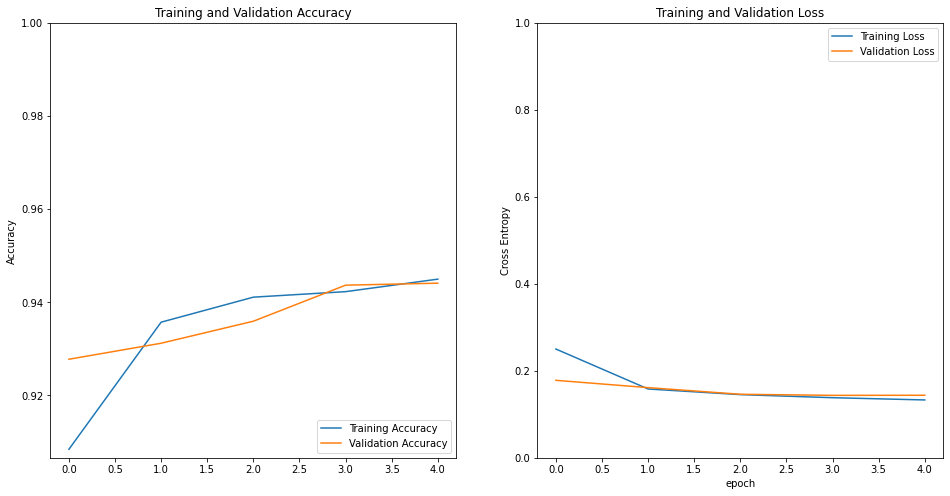

In [5]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [6]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.99981165e-01, 1.88608992e-05],
       [8.56296420e-02, 9.14370298e-01],
       [2.64149606e-01, 7.35850453e-01],
       [9.99994516e-01, 5.52718484e-06],
       [9.97587085e-01, 2.41289474e-03],
       [9.84179080e-01, 1.58208832e-02],
       [1.14175935e-04, 9.99885798e-01],
       [5.59237123e-01, 4.40762937e-01],
       [9.43742037e-01, 5.62579371e-02],
       [9.49520171e-01, 5.04798070e-02],
       [3.27520174e-05, 9.99967217e-01],
       [9.99928713e-01, 7.13278132e-05],
       [9.81147945e-01, 1.88520756e-02],
       [2.47157823e-06, 9.99997497e-01],
       [9.97837961e-01, 2.16207304e-03],
       [9.77408230e-01, 2.25917697e-02],
       [9.94867444e-01, 5.13254525e-03],
       [2.06326880e-02, 9.79367316e-01],
       [5.02397478e-01, 4.97602522e-01],
       [9.92294073e-01, 7.70588545e-03],
       [8.95985782e-01, 1.04014210e-01],
       [9.74323988e-01, 2.56760586e-02],
       [9.89613593e-01, 1.03864027e-02],
       [9.69859183e-01, 3.01408246e-02],
       [9.970928

In [7]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

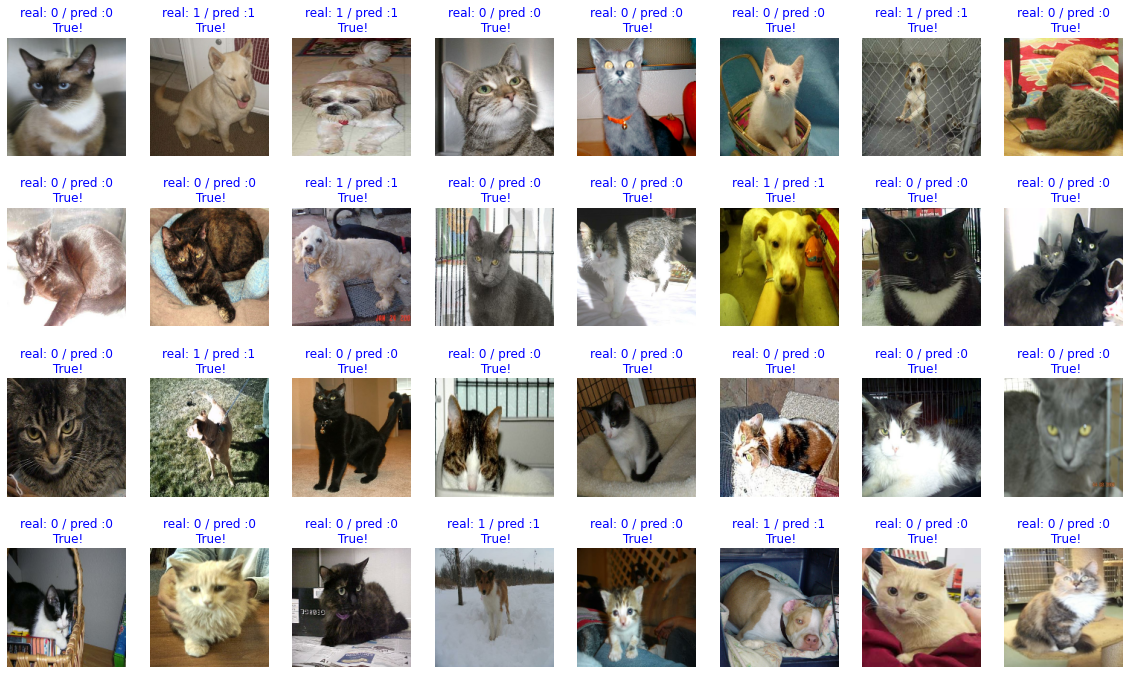

In [8]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [9]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1

print(count / 32 * 100) # 약 95% 내외

100.0


In [10]:
!mkdir -p ~/aiffel/cats_vs_dogs/checkpoint
!mkdir -p ~/aiffel/cats_vs_dogs/image

In [11]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/cats_vs_dogs/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)     # checkpoint 파일 생성

if os.path.exists(checkpoint_file_path):
  print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


In [12]:
img_dir_path = os.getenv("HOME") + "/aiffel/cats_vs_dogs/images"
os.path.exists(img_dir_path)

False

In [13]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [14]:
IMG_SIZE = 160
dog_image_path = os.path.join(img_dir_path, 'my_dog.jpeg')

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

FileNotFoundError: ignored

In [15]:
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dog_image.shape

NameError: ignored

In [16]:
prediction = model.predict(dog_image)
prediction

NameError: ignored

In [17]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    dog_percentage = round(prediction[1] * 100)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

In [18]:
filename = 'my_dog.jpeg'

show_and_predict_image(img_dir_path, filename)

FileNotFoundError: ignored

In [19]:
filename = 'my_cat.jpeg'

show_and_predict_image(img_dir_path, filename)

FileNotFoundError: ignored

In [20]:
filename = "cat_face.jpg"
show_and_predict_image(img_dir_path, filename)

FileNotFoundError: ignored